# Model generation

Based on the best parameters obtained -> it generates the model.h5 ready for CubeAI tool 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Import_functions as Imp_funct
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

Measured ODR: 6917.174621034457

ODR after resampling: 52.0


100%|███████████████████████████████████████| 248/248 [00:00<00:00, 4781.09it/s]
2022-03-11 18:04:24.267890: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 18:04:24.269161: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 594 samples, validate on 199 samples
Epoch 1/5000
594/594 [==============================] - 2s 3ms/sample - loss: 1.3889 - acc: 0.2946 - val_loss: 1.3812 - val_acc: 0.3518
Epoch 2/5000
594/594 [==============================] - 1s 2ms/sample - loss: 1.3652 - acc: 0.3535 - val_loss: 1.3639 - val_acc: 0.3116
Epoch 3/5000
594/594 [==============================] - 1s 2ms/sample - loss: 1.3420 - acc: 0.3822 - val_loss: 1.3423 - val_acc: 0.4121
Epoch 4/5000
594/594 [==============================] - 1s 2ms/sample - loss: 1.3170 - acc: 0.3704 - val_loss: 1.3199 - val_acc: 0.3417
Epoch 5/5000
594/594 [==============================] - 1s 2ms/sample - loss: 1.2790 - acc: 0.3956 - val_loss: 1.2739 - val_acc: 0.4121
Epoch 6/5000
594/594 [==============================] - 1s 2ms/sample - loss: 1.2312 - acc: 0.4327 - val_loss: 1.2731 - val_acc: 0.3719
Epoch 7/5000
594/594 [==============================] - 1s 2ms/sample - loss: 1.1997 - acc: 0.4327 - val_loss: 1.2334 - val_acc: 0.4121
Ep

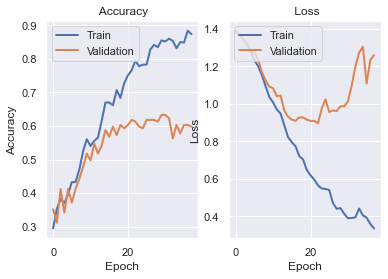

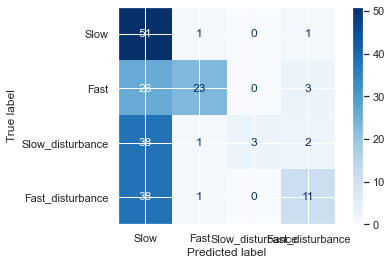

precision:  [0.33333333 0.88461538 1.         0.64705882]
recall:  [0.96226415 0.44230769 0.06818182 0.22      ]
Do you want to save this model? yes/no: yes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Saved_models/motor_4classes/assets


2022-03-11 18:05:10.532475: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [2]:
# Create the model 
model_name = 'motor_4classes'

Resampling_frequency = 52

df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = Imp_funct.load_data(resampling_active=True, Resampling_frequency=Resampling_frequency)

window_length=100   # Number of samples considered in the window
sliding_samples=int(window_length/2)   # Overlapped samples 

X_S = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_S, sliding_samples ,window_length)
X_SD = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_F, sliding_samples ,window_length)
X_F = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_SD, sliding_samples ,window_length)
X_FD = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_FD, sliding_samples ,window_length)

y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

X = np.concatenate((X_S,X_F,X_SD,X_FD),axis=0)
y = np.concatenate((y_S,y_F,y_SD,y_FD),axis=0)

# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]

# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb.fit(y)
y=lb.transform(y)

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

outputShape=trainY.shape[1]
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D( trainX.shape[ 1 ], ( 5, 1 ), input_shape = ( trainX.shape[ 1 ], trainX.shape[ 2 ],trainX.shape[ 3 ] ), activation = 'relu' ),
    tf.keras.layers.MaxPooling2D( pool_size = ( 3, 1 ) ),
    tf.keras.layers.Flatten( ),
    tf.keras.layers.Dense( 12 ),
    tf.keras.layers.Dense( 12 ),
    tf.keras.layers.Dropout( 0.5 ),
    tf.keras.layers.Dense( outputShape, activation = 'softmax' ) 
    ])


learningRate = 3e-3
batchSize = 128

# Train and evaluate the model 
# Early stopping applied to val_loss 
model, score = Imp_funct.evaluate_model(trainX, trainY ,
                                 validationX, validationY, 
                                 testX, testY, 
                                 model,
                                 learningRate = learningRate,
                                 batchSize = batchSize,
                                 verbosity = 1,
                                 learning_curves = True, ConfusionMatrix = True)



Imp_funct.modelSave(model, model_name)


# Transfer learning and Fine Tuning

Re-Train the model with new data

- n_last_trainable_layers: number of trainable layers starting from the outer one (if -1 all layers are trainable)
- out_layer: it is possible to add out_layer = False so that the imported model is without the last classification layer in case new classes must be added to the model


Measured ODR: 6917.174621034457

ODR after resampling: 52.0


100%|███████████████████████████████████████| 248/248 [00:00<00:00, 4816.08it/s]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 3, 100)        600       
_________________________________________________________________
sequential_1 (Sequential)    (None, 12)                115212    
_________________________________________________________________
sequential_3 (Sequential)    (None, 12)                156       
_________________________________________________________________
sequential_4 (Sequential)    (None, 4)                 52        
Total params: 116,020
Trainable params: 208
Non-trainable params: 115,812
_________________________________________________________________
Train on 594 samples, validate on 199 samples
Epoch 1/5000
594/594 [==============================] - 1s 2ms/sample - loss: 0.8115 - acc: 0.6616 - val_loss: 0.6310 - val_acc: 0.7437
Epoch 2/5000
594/594 [==============================] - 1s 1ms

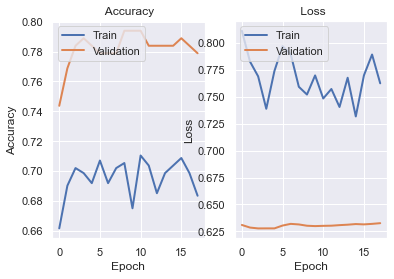

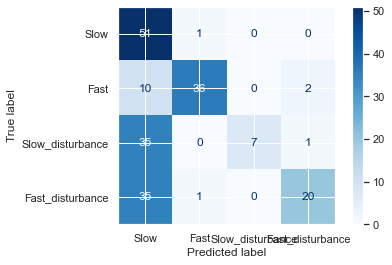

precision:  [0.38931298 0.94736842 1.         0.86956522]
recall:  [0.98076923 0.75       0.1627907  0.35714286]
Do you want to save this model? yes/no: yes
Do you want to overwrite this model? yes/no: yes
INFO:tensorflow:Assets written to: Saved_models/motor_4classes/assets


In [3]:
# load and prepare new training data for the model 
model_name = 'motor_4classes'

Resampling_frequency = 52

df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = Imp_funct.load_data(resampling_active=True, Resampling_frequency=Resampling_frequency)

window_length=100   # Number of samples considered in the window
sliding_samples=int(window_length/2)   # Overlapped samples 

X_S = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_S, sliding_samples ,window_length)
X_SD = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_F, sliding_samples ,window_length)
X_F = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_SD, sliding_samples ,window_length)
X_FD = Imp_funct.CNN_time_series_sorting_input_matrix(df_ACC_FD, sliding_samples ,window_length)

y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

X = np.concatenate((X_S,X_F,X_SD,X_FD),axis=0)
y = np.concatenate((y_S,y_F,y_SD,y_FD),axis=0)

# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]

# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb.fit(y)
y=lb.transform(y)

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)


learningRate = 3e-3
batchSize = 128


model = Imp_funct.load_existing_model(model_name = model_name, n_last_trainable_layers = 3)

# Train the model 
model, score = Imp_funct.evaluate_model(trainX, trainY ,
                                 validationX, validationY, 
                                 testX, testY, 
                                 model,
                                 learningRate = learningRate,
                                 batchSize = batchSize,
                                 verbosity = 1,
                                 learning_curves = True, ConfusionMatrix = True)


Imp_funct.modelSave(model, model_name)

